In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image
import warnings
warnings.filterwarnings('ignore')
import torch
import random

In [2]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]
available_gpus

In [4]:
directory = 'trainingSet'
image_list = []
labels = []
list_folders = os.listdir(directory)
for folders in list_folders:
    images = os.listdir(f'{directory}/{folders}')
    for image in images:
        image_dir = f'{directory}/{folders}/{image}'
        image_list.append(image_dir)
        labels.append(folders)
        

#randomizing the dataset
image_list = np.array(image_list)
labels = np.array(labels)
randomize = np.arange(len(labels))
np.random.shuffle(randomize)
image_list = image_list[randomize]
labels = labels[randomize]

#splitting the dataset into training and testing part
train_image_list = image_list[0:int(len(image_list)*0.9)]
test_image_list = image_list[int(len(image_list)*0.9):]
train_labels = labels[0:int(len(image_list)*0.9)]
test_labels = labels[int(len(image_list)*0.9):]

In [5]:
def preprocess_input(img):
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    y, u, v = cv2.split(img)
    y = y / 255.0
    x = np.array(y.flatten()).reshape(1,784)
    return x

In [6]:
#Activation Functions
def sigmoid(x):
    return torch.sigmoid(x)

def softmax(x):
    maxes = torch.max(x, 1, keepdim=True)[0]
    x_exp = torch.exp(x-maxes)
    x_exp_sum = torch.sum(x_exp, 1, keepdim=True)
    return x_exp/x_exp_sum

def tanh(x):
    return math.tanh(x)

def relu(x):
    return x * (x > 0)

def create_dropout_mask(shape, rate=0.20):
    mask = np.ones(shape).astype('float32')
    total_num = int(shape[1] * rate)
    random_list = random.sample(range(0, shape[1]), total_num)
    for i in random_list:
        mask[0][i] = 0
    mask = torch.from_numpy(mask)
    mask = mask.to(device)
    return mask

 # Network with 5 Hidden Layers

## 1. Weight Initialization

In [7]:
input_layer = 784
hidden_layer1 = 392
hidden_layer2 = 196
hidden_layer3 = 64
hidden_layer4 = 32
output_layer = 10

def initialize_weights_and_bias(mode, distribution='uniform'):
    '''
    Initialize weights and bias for neural network layers using the specified distribution. 
    '''

    if mode == 'random':
        W1 = np.random.random((hidden_layer1, input_layer)).astype(np.float32)   #784x392
        b1 = np.random.random((1, hidden_layer1)).astype(np.float32)             #1x392
        W2 = np.random.random((hidden_layer1, hidden_layer2)).astype(np.float32) #392x196
        b2 = np.random.random((1, hidden_layer2)).astype(np.float32)             #1x196
        W3 = np.random.random((hidden_layer2, hidden_layer3)).astype(np.float32) #196x64
        b3 = np.random.random((1, hidden_layer3)).astype(np.float32)             #1x64
        W4 = np.random.random((hidden_layer3, hidden_layer4)).astype(np.float32) #64x32
        b4 = np.random.random((1, hidden_layer4)).astype(np.float32)             #1x32
        W5 = np.random.random((hidden_layer4, output_layer)).astype(np.float32)  #32x10
        b5 = np.random.random((1, output_layer)).astype(np.float32)              #1x10
    elif mode == 'xavier':
        if distribution == 'normal':
            W1 = np.random.normal(loc=0.0, scale=np.sqrt(2/(hidden_layer1 + input_layer)), size=((hidden_layer1, input_layer))).astype(np.float32)    #784x392
            b1 = np.random.normal(loc=0.0, scale=np.sqrt(2/(1+hidden_layer1)), size=((1, hidden_layer1))).astype(np.float32)              #1x392   
            W2 = np.random.normal(loc=0.0, scale=np.sqrt(2/(hidden_layer1 + hidden_layer2)), size=((hidden_layer1, hidden_layer2))).astype(np.float32)  #392x196
            b2 = np.random.normal(loc=0.0, scale=np.sqrt(2/(1 + hidden_layer2)), size=((1, hidden_layer2))).astype(np.float32)              #1x196
            W3 = np.random.normal(loc=0.0, scale=np.sqrt(2/(hidden_layer2 + hidden_layer3)), size=((hidden_layer2, hidden_layer3))).astype(np.float32)  #196x64
            b3 = np.random.normal(loc=0.0, scale=np.sqrt(2/(1 + hidden_layer3)), size=((1, hidden_layer3))).astype(np.float32)              #1x64
            W4 = np.random.normal(loc=0.0, scale=np.sqrt(2/(hidden_layer3 + hidden_layer4)), size=((hidden_layer3, hidden_layer4))).astype(np.float32)  #64x32
            b4 = np.random.normal(loc=0.0, scale=np.sqrt(2/(1 + hidden_layer4)), size=((1, hidden_layer4))).astype(np.float32)              #1x32
            W5 = np.random.normal(loc=0.0, scale=np.sqrt(2/(hidden_layer4 + output_layer)), size=((hidden_layer4, output_layer))).astype(np.float32)   #32x10
            b5 = np.random.normal(loc=0.0, scale=np.sqrt(2/(1 + output_layer)), size=((1, output_layer))).astype(np.float32)               #1x10
        elif distribution == 'uniform':
            W1 = np.random.uniform(low = -np.sqrt(6/(hidden_layer1 + input_layer)), high = np.sqrt(6/(hidden_layer1 + input_layer)), size=((hidden_layer1, input_layer))).astype(np.float32)   #392x784
            b1 = np.random.uniform(low = -np.sqrt(6/(1+hidden_layer1)), high = np.sqrt(6/(1+hidden_layer1)), size=((1, hidden_layer1))).astype(np.float32)             #1x392
            W2 = np.random.uniform(low = -np.sqrt(6/(hidden_layer1 + hidden_layer2)), high = np.sqrt(6/(hidden_layer1 + hidden_layer2)), size=((hidden_layer2, hidden_layer1))).astype(np.float32) #392x196
            b2 = np.random.uniform(low = -np.sqrt(6/(1 + hidden_layer2)), high = np.sqrt(6/(1 + hidden_layer2)), size=((1, hidden_layer2))).astype(np.float32)             #1x196
            W3 = np.random.uniform(low = -np.sqrt(6/(hidden_layer2 + hidden_layer3)), high = np.sqrt(6/(hidden_layer2 + hidden_layer3)), size=((hidden_layer3, hidden_layer2))).astype(np.float32) #196x64
            b3 = np.random.uniform(low = -np.sqrt(6/(1 + hidden_layer3)), high = np.sqrt(6/(1 + hidden_layer3)), size=((1, hidden_layer3))).astype(np.float32)             #1x64
            W4 = np.random.uniform(low = -np.sqrt(6/(hidden_layer3 + hidden_layer4)), high = np.sqrt(6/(hidden_layer3 + hidden_layer4)), size=((hidden_layer4, hidden_layer3))).astype(np.float32) #64x32
            b4 = np.random.uniform(low = -np.sqrt(6/(1 + hidden_layer4)), high = np.sqrt(6/(1 + hidden_layer4)), size=((1, hidden_layer4))).astype(np.float32)             #1x32
            W5 = np.random.uniform(low = -np.sqrt(6/(hidden_layer4 + output_layer)), high = np.sqrt(6/(hidden_layer4 + output_layer)), size=((output_layer, hidden_layer4))).astype(np.float32)  #32x10
            b5 = np.random.uniform(low = -np.sqrt(6/(1 + output_layer)), high = np.sqrt(6/(1 + output_layer)), size=((1, output_layer))).astype(np.float32)              #1x10
    elif mode == 'constant':
        W1 = np.ones((hidden_layer1, input_layer)).astype(np.float32)     #784x392
        b1 = np.ones((1, hidden_layer1)).astype(np.float32)               #1x392
        W2 = np.ones((hidden_layer1, hidden_layer2)).astype(np.float32)   #392x196
        b2 = np.ones((1, hidden_layer2)).astype(np.float32)               #1x196
        W3 = np.ones((hidden_layer2, hidden_layer3)).astype(np.float32)   #196x64
        b3 = np.ones((1, hidden_layer3)).astype(np.float32)               #1x64
        W4 = np.ones((hidden_layer3, hidden_layer4)).astype(np.float32)   #64x32
        b4 = np.ones((1, hidden_layer4)).astype(np.float32)               #1x32 
        W5 = np.ones((hidden_layer4, output_layer)).astype(np.float32)    #32x10
        b5 = np.ones((1, output_layer)).astype(np.float32)                #1x10
    elif mode == 'zero':
        W1 = np.zeros((hidden_layer1, input_layer)).astype(np.float32)
        b1 = np.zeros((1, hidden_layer1)).astype(np.float32)
        W2 = np.zeros((hidden_layer1, hidden_layer2)).astype(np.float32)
        b2 = np.zeros((1, hidden_layer2)).astype(np.float32)
        W3 = np.zeros((hidden_layer2, hidden_layer3)).astype(np.float32)
        b3 = np.zeros((1, hidden_layer3)).astype(np.float32)
        W4 = np.zeros((hidden_layer3, hidden_layer4)).astype(np.float32)
        b4 = np.zeros((1, hidden_layer4)).astype(np.float32)
        W5 = np.zeros((hidden_layer4, output_layer)).astype(np.float32)
        b5 = np.zeros((1, output_layer)).astype(np.float32)
    else:
        print('Error: mode not recognized')
        return
    

    return W1, b1, W2, b2, W3, b3, W4, b4, W5, b5  

## 2. A Forward Pass Function of 5 layers, with a droput layer on our First and Third layer.

In [8]:
def forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, training=True):
    
    
    x = np.array(x, dtype=np.float32)                 #784x1
    x = torch.from_numpy(x)
    x = x.to('cuda')
    
    
    #First layer
    res1 = torch.mm(x, W1.T) + b1                    #392x1
    layer1_out = sigmoid(res1)                        #392x1
    if training == True:
        mask1 = create_dropout_mask(layer1_out.shape)
        layer1_out = layer1_out * mask1
    # print(layer1_out)                 
    
    #Second layer
    res2 = torch.mm(layer1_out, W2.T) + b2          #196x1
    layer2_out = sigmoid(res2)                       #196x1
    #print(layer2_out)                                
    
    #Third layer
    res3 = torch.mm(layer2_out, W3.T) + b3         #64x1
    layer3_out = sigmoid(res3)                      #64x1
    if training == True:
        mask3 = create_dropout_mask(layer3_out.shape)
        layer3_out = layer3_out * mask3
    #print(layer3_out)
    
    #Fourth Layer
    res4 = torch.mm(layer3_out, W4.T) + b4        #32x1
    layer4_out = sigmoid(res4)                     #32x1
    #print(layer4_out)
    
    #Fifth Layer
    res5 = torch.mm(layer4_out, W5.T) + b5        #10x1
    layer5_out = softmax(res5)                     #10x1
    #print(layer5_out)
    
    
    return layer1_out.flatten(), layer2_out.flatten(), layer3_out.flatten(), layer4_out.flatten(), layer5_out.flatten()

## 3. A Backward Pass function, which computes the gradient of each layer.

In [9]:
def backward_pass(x, y, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, z1, z2, z3, z4, y_hat):
    
    x = np.array(x, dtype= np.float32).reshape(1,784)
    y = np.array(y, dtype = np.float32).reshape(1,10)
    y_hat = np.array(y_hat, dtype=np.float32).reshape(1,10)
    z1 = np.array(z1.cpu(), dtype=np.float32).reshape(1, 392)
    z2 = np.array(z2.cpu(), dtype=np.float32).reshape(1, 196)
    z3 = np.array(z3.cpu(), dtype=np.float32).reshape(1, 64)
    z4 = np.array(z4.cpu(), dtype=np.float32).reshape(1, 32)

    #converting the arrays to tensors
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    z1 = torch.from_numpy(z1)
    z2 = torch.from_numpy(z2)
    z3 = torch.from_numpy(z3)
    z4 = torch.from_numpy(z4)
    y_hat = torch.from_numpy(y_hat)

    #allocating the memory in device for our tensors
    x = x.to('cuda')
    y = y.to('cuda')
    z1 = z1.to('cuda')
    z2 = z2.to('cuda')
    z3 = z3.to('cuda')
    z4 = z4.to('cuda')
    y_hat = y_hat.to('cuda')


    
    #Final Layer
    db5 = (y_hat-y)                                              
    dw5 = torch.mm(db5.T, z4)                                         
    
    #Fourth Layer
    db4 = torch.mm(torch.mm(torch.mm(db5, W5).T, z4), (1-z4).T).T   
    dw4 = torch.mm(db4.T, z3)                                         
    
    #Third Layer
    db3 = torch.mm(torch.mm(torch.mm(db4, W4).T, z3), (1-z3).T).T   
    dw3 = torch.mm(db3.T, z2)                                        
    
    #Second Layer
    db2 = torch.mm(torch.mm(torch.mm(db3, W3).T, z2), (1-z2).T).T   
    dw2 = torch.mm(db2.T, z1) 

    #First Layer
    db1 = torch.mm(torch.mm(torch.mm(db2, W2).T, z1), (1-z1).T).T   
    dw1 = torch.mm(db1.T, x) 


    return dw1, db1, dw2, db2, dw3, db3, dw4, db4, dw5, db5

## Now the Training Begins with MiniBatch Gradient with AdaGrad

For this to work, we first compute the gradient of a minibatch. Firstly, we compute the gradient of each input in our minibatch size and take the average gradient of it, and then only update our weights using AdaGrad optimizer using our average gradient of the minibatch. The adagrad optimizer is defined by:

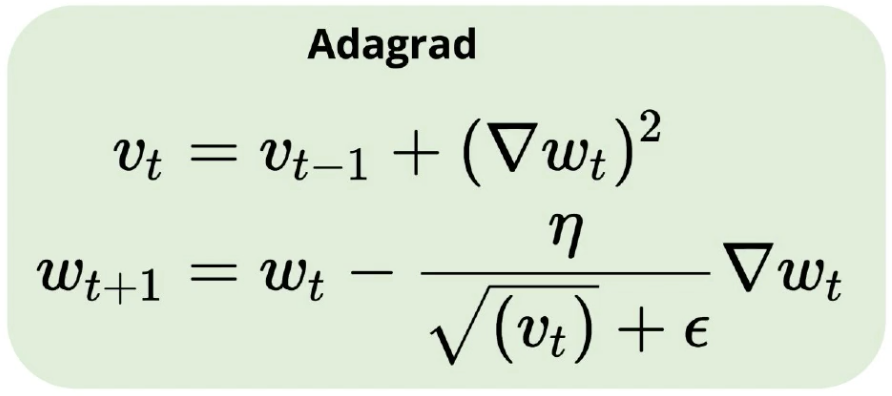

Where, Delta of W is defined as the average gradient of our function.

In [10]:
import matplotlib.pyplot as plt


W1, b1, W2, b2, W3, b3, W4, b4, W5, b5 = initialize_weights_and_bias(mode='xavier', distribution='uniform')
W1 = torch.from_numpy(W1)
b1 = torch.from_numpy(b1)
W2 = torch.from_numpy(W2)
b2 = torch.from_numpy(b2)
W3 = torch.from_numpy(W3)
b3 = torch.from_numpy(b3)
W4 = torch.from_numpy(W4)
b4 = torch.from_numpy(b4)
W5 = torch.from_numpy(W5)
b5 = torch.from_numpy(b5)
W1 = W1.to('cuda')
b1 = b1.to('cuda')
W2 = W2.to('cuda')
b2 = b2.to('cuda')
W3 = W3.to('cuda')
b3 = b3.to('cuda')
W4 = W4.to('cuda')
b4 = b4.to('cuda')
W5 = W5.to('cuda')
b5 = b5.to('cuda')

target = np.array(train_labels)
# target = torch.from_numpy(target)
# target.to('cuda')

cost = 0
losses = []
epochs = 10
batch_size = 200
epsilon = 10e-8
lr = 0.01

for j in range(epochs):
    losss = 0
    tp = 0
    
    VW1, Vb1, VW2, Vb2, VW3, Vb3, VW4, Vb4, VW5, Vb5 = initialize_weights_and_bias(mode='zero')
    VW1 = torch.from_numpy(VW1)
    VW1= VW1.to('cuda')
    Vb1 = torch.from_numpy(Vb1)
    Vb1 = Vb1.to('cuda')
    VW2 = torch.from_numpy(VW2)
    VW2 = VW2.to('cuda')
    Vb2 = torch.from_numpy(Vb2)
    Vb2 = Vb2.to('cuda')
    VW3 = torch.from_numpy(VW3)
    VW3 = VW3.to('cuda')
    Vb3 = torch.from_numpy(Vb3)
    Vb3 = Vb3.to('cuda')
    VW4 = torch.from_numpy(VW4)
    VW4 = VW4.to('cuda')
    Vb4 = torch.from_numpy(Vb4)
    Vb4 = Vb4.to('cuda')
    VW5 = torch.from_numpy(VW5)
    VW5 = VW5.to('cuda')
    Vb5 = torch.from_numpy(Vb5)
    Vb5 = Vb5.to('cuda')

    
    for i in range(int(len(train_image_list)/batch_size) - 1):
        
        tW1, tb1, tW2, tb2, tW3, tb3, tW4, tb4, tW5, tb5 = initialize_weights_and_bias(mode='zero')
        tW1 = torch.from_numpy(tW1)
        tW1 = tW1.to('cuda')
        tb1 = torch.from_numpy(tb1)
        tb1 = tb1.to('cuda')
        tW2 = torch.from_numpy(tW2)
        tW2 = tW2.to('cuda')
        tb2 = torch.from_numpy(tb2)
        tb2 = tb2.to('cuda')
        tW3 = torch.from_numpy(tW3)
        tW3 = tW3.to('cuda')
        tb3 = torch.from_numpy(tb3)
        tb3 = tb3.to('cuda')
        tW4 = torch.from_numpy(tW4)
        tW4 = tW4.to('cuda')
        tb4 = torch.from_numpy(tb4)
        tb4 = tb4.to('cuda')
        tW5 = torch.from_numpy(tW5)
        tW5 = tW5.to('cuda')
        tb5 = torch.from_numpy(tb5)
        tb5 = tb5.to('cuda')
        
        


        for k in range(batch_size):
        
            
            img = cv2.imread(train_image_list[i * batch_size + k])
            x = preprocess_input(img)
            y = np.zeros(10)
            y[int(target[i * batch_size + k])] = 1
            
            #network forward pass
            z1, z2, z3, z4, y_hat = forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, training=True)
            y_hat = y_hat.cpu()
            y_hat = np.array(y_hat)

            #the true positives for this case, to calculate accuracy
            if np.argmax(y_hat) == np.argmax(y):
                tp += 1

            #we use categorical cross entropy loss
            loss = 0
            for i in range(len(y)):
                if y[i] != 0:
                    loss +=  -y[i] * np.log(y_hat[i])
            losss += loss


            #network backward pass
            dW1, db1, dW2, db2, dW3, db3, dW4, db4, dW5, db5 = backward_pass(x, y, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, z1, z2, z3, z4, y_hat)


            #take average of t-variables
            tW1 = torch.add(tW1, dW1)
            tb1 = torch.add(tb1, db1)
            tW2 = torch.add(tW2, dW2.T)
            tb2 = torch.add(tb2, db2)
            tW3 = torch.add(tW3, dW3.T)
            tb3 = torch.add(tb3, db3)
            tW4 = torch.add(tW4, dW4.T)
            tb4 = torch.add(tb4, db4)
            tW5 = torch.add(tW5, dW5.T)
            tb5 = torch.add(tb5, db5)
            
        #take average
        tW1 = tW1/batch_size
        tb1 = tb1/batch_size
        tW2 = tW2/batch_size
        tb2 = tb2/batch_size
        tW3 = tW3/batch_size
        tb3 = tb3/batch_size
        tW4 = tW4/batch_size
        tb4 = tb4/batch_size
        tW5 = tW5/batch_size
        tb5 = tb5/batch_size

        #update V weights and bias
        VW1 = torch.add(VW1, tW1**2)
        Vb1 = torch.add(Vb1, tb1**2)
        VW2 = torch.add(VW2, tW2**2)
        Vb2 = torch.add(Vb2, tb2**2)
        VW3 = torch.add(VW3, tW3**2)
        Vb3 = torch.add(Vb3, tb3**2)
        VW4 = torch.add(VW4, tW4**2)
        Vb4 = torch.add(Vb4, tb4**2)
        VW5 = torch.add(VW5, tW5**2)
        Vb5 = torch.add(Vb5, tb5**2)

        #update weights and bias
        W1 = W1 - lr/torch.sqrt(VW1+epsilon) * tW1
        b1 = b1 - lr/torch.sqrt(Vb1+epsilon) * tb1
        W2 = W2 - (lr/torch.sqrt(VW2+epsilon) * tW2).T
        b2 = b2 - lr/torch.sqrt(Vb2+epsilon) * tb2
        W3 = W3 - (lr/torch.sqrt(VW3+epsilon) * tW3).T
        b3 = b3 - lr/torch.sqrt(Vb3+epsilon) * tb3
        W4 = W4 - (lr/torch.sqrt(VW4+epsilon) * tW4).T
        b4 = b4 - lr/torch.sqrt(Vb4+epsilon) * tb4
        W5 = W5 - (lr/torch.sqrt(VW5+epsilon) * tW5).T
        b5 = b5 - lr/torch.sqrt(Vb5+epsilon) * tb5


    #we append total loss of each epoch to the losses array
    losses.append(losss)
    print(f"Epoch = {j}, Accuracy = {tp/len(train_image_list)}, loss= {losss}")

Epoch = 0, Accuracy = 0.3930952380952381, loss= 58689.09623795748
Epoch = 1, Accuracy = 0.6369312169312169, loss= 35148.07193554565
Epoch = 2, Accuracy = 0.7405820105820106, loss= 25537.89887996111
Epoch = 3, Accuracy = 0.7944708994708994, loss= 20816.61036361498
Epoch = 4, Accuracy = 0.8438888888888889, loss= 17366.015680198092
Epoch = 5, Accuracy = 0.8863227513227513, loss= 13319.523604219052
Epoch = 6, Accuracy = 0.9034656084656084, loss= 10740.933277001051
Epoch = 7, Accuracy = 0.9181216931216931, loss= 9031.485223534386
Epoch = 8, Accuracy = 0.9257671957671958, loss= 8151.581824383913
Epoch = 9, Accuracy = 0.9214021164021164, loss= 8276.56504200671


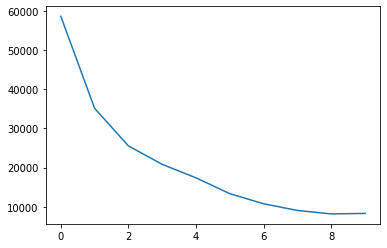

In [11]:
# print(losses)
plt.plot(losses)
plt.show()

## Predicting a few cases

Actual: 6 | Predicted: 2


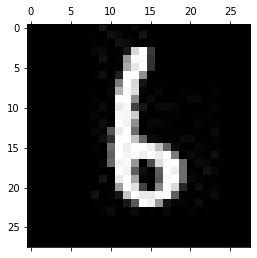

In [12]:
entry = 12
img = cv2.imread(test_image_list[entry])
plt.matshow(img)
x = preprocess_input(img)
z1, z2, z3, z4, y_hat = forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5)
y_hat = y_hat.cpu()
print(f'Actual: {test_labels[entry]} | Predicted: {np.argmax(y_hat)}')

In [13]:
tp_test = 0

for i in range(len(test_image_list)):
    img = cv2.imread(test_image_list[i])
    x = preprocess_input(img)
    target = np.array(test_labels)
    y = np.zeros(10)
    y[int(target[i])] = 1


    #network forward pass
    z1, z2, z3, z4, y_hat = forward_pass(x, W1, b1, W2, b2, W3, b3, W4, b4, W5, b5, training=False)
    
    y_hat = y_hat.cpu()
    
    print(f"{np.argmax(y_hat)} \ {np.argmax(y)}")
    
    if np.argmax(y_hat) == np.argmax(y):
        tp_test += 1

6 \ 6
1 \ 1
7 \ 7
3 \ 5
9 \ 9
3 \ 3
9 \ 9
4 \ 9
8 \ 7
2 \ 2
3 \ 2
7 \ 7
2 \ 6
3 \ 3
9 \ 9
3 \ 3
7 \ 7
1 \ 1
3 \ 1
1 \ 1
1 \ 3
1 \ 3
5 \ 5
3 \ 3
1 \ 1
7 \ 7
6 \ 6
7 \ 7
7 \ 7
1 \ 3
1 \ 1
0 \ 0
3 \ 8
5 \ 5
9 \ 7
1 \ 8
2 \ 2
2 \ 2
3 \ 2
4 \ 6
8 \ 8
0 \ 0
1 \ 1
8 \ 8
2 \ 6
2 \ 7
6 \ 5
5 \ 0
8 \ 8
3 \ 5
4 \ 4
3 \ 3
2 \ 2
9 \ 7
2 \ 6
1 \ 5
3 \ 8
2 \ 4
9 \ 9
9 \ 7
1 \ 8
1 \ 3
5 \ 0
8 \ 8
5 \ 5
3 \ 3
8 \ 5
1 \ 1
1 \ 1
9 \ 9
4 \ 2
2 \ 4
8 \ 3
3 \ 5
0 \ 0
3 \ 8
3 \ 2
3 \ 3
4 \ 4
1 \ 1
9 \ 4
1 \ 1
2 \ 6
3 \ 6
2 \ 2
7 \ 7
9 \ 7
5 \ 5
4 \ 4
2 \ 2
0 \ 0
5 \ 2
8 \ 8
5 \ 5
5 \ 5
0 \ 0
9 \ 4
1 \ 1
9 \ 4
2 \ 2
4 \ 2
5 \ 0
2 \ 4
9 \ 9
0 \ 0
2 \ 6
0 \ 0
3 \ 3
5 \ 5
1 \ 3
5 \ 8
1 \ 9
9 \ 9
9 \ 9
0 \ 0
5 \ 8
3 \ 1
3 \ 3
9 \ 9
9 \ 9
7 \ 7
5 \ 8
2 \ 4
8 \ 5
0 \ 0
3 \ 8
6 \ 0
6 \ 4
2 \ 2
9 \ 9
0 \ 0
9 \ 7
2 \ 2
3 \ 3
4 \ 4
7 \ 7
7 \ 9
1 \ 1
1 \ 3
5 \ 8
2 \ 3
1 \ 1
0 \ 0
8 \ 8
2 \ 6
7 \ 7
6 \ 6
7 \ 7
5 \ 5
2 \ 2
9 \ 9
9 \ 9
8 \ 8
7 \ 7
1 \ 1
7 \ 7
5 \ 8
1 \ 1
2 \ 6
1 \ 1
8 \ 8
8 \ 4
3 \ 2
9 \ 4
9 \ 9
4 \ 4
9 \ 

3 \ 5
6 \ 6
0 \ 0
5 \ 3
7 \ 5
0 \ 0
7 \ 7
9 \ 7
0 \ 0
2 \ 2
1 \ 1
6 \ 3
2 \ 2
1 \ 1
1 \ 1
3 \ 3
2 \ 2
5 \ 3
4 \ 4
6 \ 6
4 \ 4
0 \ 0
2 \ 8
6 \ 6
4 \ 4
1 \ 1
0 \ 0
2 \ 2
1 \ 1
1 \ 1
9 \ 7
8 \ 1
5 \ 3
1 \ 1
3 \ 2
5 \ 9
5 \ 5
0 \ 0
1 \ 1
5 \ 5
6 \ 6
5 \ 0
1 \ 1
1 \ 1
2 \ 6
9 \ 9
3 \ 8
9 \ 7
6 \ 6
6 \ 6
3 \ 3
9 \ 4
8 \ 5
9 \ 7
3 \ 3
3 \ 8
2 \ 4
0 \ 0
6 \ 0
2 \ 6
2 \ 6
1 \ 1
6 \ 0
2 \ 2
1 \ 1
6 \ 5
3 \ 3
3 \ 8
9 \ 9
7 \ 7
6 \ 6
9 \ 9
5 \ 5
0 \ 0
3 \ 3
0 \ 0
2 \ 6
9 \ 9
0 \ 0
1 \ 1
1 \ 1
8 \ 8
4 \ 4
9 \ 4
5 \ 8
3 \ 5
5 \ 5
8 \ 8
3 \ 8
6 \ 6
0 \ 0
6 \ 6
1 \ 1
0 \ 0
4 \ 4
5 \ 5
9 \ 9
8 \ 8
5 \ 5
0 \ 0
6 \ 6
9 \ 7
5 \ 8
9 \ 9
3 \ 3
1 \ 1
2 \ 5
4 \ 7
1 \ 1
9 \ 9
3 \ 3
3 \ 3
4 \ 4
3 \ 3
7 \ 7
2 \ 4
4 \ 4
9 \ 9
3 \ 1
9 \ 9
6 \ 6
3 \ 2
1 \ 1
4 \ 4
5 \ 7
7 \ 7
1 \ 5
9 \ 9
7 \ 7
0 \ 0
4 \ 4
2 \ 2
3 \ 2
2 \ 2
9 \ 9
0 \ 0
4 \ 4
1 \ 7
5 \ 3
9 \ 9
5 \ 4
6 \ 6
9 \ 9
3 \ 8
1 \ 1
3 \ 2
2 \ 4
2 \ 2
6 \ 6
7 \ 4
1 \ 1
5 \ 0
7 \ 7
3 \ 3
3 \ 2
7 \ 7
8 \ 5
3 \ 2
2 \ 4
5 \ 8
3 \ 2
1 \ 1
6 \ 6
8 \ 8
6 \ 6
9 \ 9
2 \ 

1 \ 1
4 \ 4
1 \ 1
9 \ 9
2 \ 2
3 \ 8
9 \ 7
3 \ 8
9 \ 9
6 \ 0
5 \ 5
7 \ 7
5 \ 5
4 \ 4
2 \ 4
8 \ 9
7 \ 7
1 \ 1
9 \ 4
5 \ 4
9 \ 9
4 \ 4
3 \ 5
6 \ 6
1 \ 1
0 \ 4
9 \ 9
4 \ 4
0 \ 0
1 \ 2
6 \ 6
0 \ 0
9 \ 9
6 \ 6
0 \ 0
4 \ 4
2 \ 5
2 \ 6
6 \ 6
1 \ 1
3 \ 2
9 \ 2
0 \ 0
3 \ 3
7 \ 7
0 \ 0
5 \ 5
1 \ 1
9 \ 7
9 \ 7
5 \ 5
0 \ 0
9 \ 1
3 \ 3
3 \ 3
4 \ 9
4 \ 2
3 \ 3
9 \ 7
1 \ 4
9 \ 9
3 \ 3
4 \ 9
0 \ 0
5 \ 8
2 \ 2
9 \ 9
5 \ 5
3 \ 3
6 \ 6
7 \ 7
8 \ 7
1 \ 1
2 \ 2
1 \ 1
4 \ 4
3 \ 8
1 \ 1
6 \ 6
1 \ 1
5 \ 5
3 \ 3
6 \ 3
9 \ 9
0 \ 0
4 \ 4
1 \ 1
1 \ 2
4 \ 4
4 \ 2
7 \ 7
2 \ 2
2 \ 6
2 \ 2
1 \ 7
9 \ 9
0 \ 0
0 \ 0
2 \ 6
0 \ 0
2 \ 2
8 \ 8
1 \ 1
6 \ 6
6 \ 6
1 \ 1
5 \ 5
9 \ 9
8 \ 8
1 \ 1
3 \ 3
8 \ 4
4 \ 4
5 \ 0
6 \ 4
9 \ 9
8 \ 7
1 \ 1
7 \ 7
3 \ 3
5 \ 5
3 \ 4
1 \ 9
4 \ 4
5 \ 0
1 \ 1
6 \ 0
5 \ 5
5 \ 8
2 \ 2
8 \ 8
9 \ 1
2 \ 4
6 \ 6
0 \ 5
6 \ 6
2 \ 0
3 \ 3
4 \ 4
4 \ 3
0 \ 0
2 \ 5
3 \ 8
4 \ 9
6 \ 6
8 \ 7
3 \ 3
1 \ 1
3 \ 2
6 \ 0
0 \ 0
1 \ 8
1 \ 1
6 \ 9
7 \ 7
9 \ 9
6 \ 6
2 \ 5
3 \ 1
5 \ 2
2 \ 6
0 \ 0
2 \ 6
9 \ 7
4 \ 6
2 \ 3
7 \ 

1 \ 1
3 \ 1
3 \ 8
1 \ 1
6 \ 0
5 \ 0
3 \ 8
4 \ 4
7 \ 7
0 \ 0
5 \ 3


In [14]:
print(f"Accuracy for test data: {round(tp_test/len(test_image_list), 2)*100}%")

Accuracy for test data: 62.0%
